# Introduction

The goal of this notebook is to analysis the amount of movement in the CDR loops a given TCR can have between its *apo* (unbound) and *holo* (bound) forms. The hypothesis is that there will be some changes- measured by RMSD- captured in the different *apo* forms, and a lot more change between the *apo* and *holo* forms.

In [1]:
import os

import matplotlib.pyplot as plt
import nglview
import pandas as pd
import seaborn as sns
from tcr_structure_tools.parsers import parse_pdb, stringify_structure
from tcr_structure_tools.extract import extract_tcr, get_remark
from tcr_structure_tools.apps.extract_tcr_structures import get_chains

The first dataset to be loaded is a set containing all of the varaible domain sequence information for every TCR contained in the [STCRDab](https://opig.stats.ox.ac.uk/webapps/stcrdab-stcrpred/). These entries also contain information about whether the TCR is in its *apo* or *holo* form based on the column `complex`.

In [2]:
stcrdab_cdr_seqs = pd.read_pickle('../data/TCRs_CDR_seqs_STCRDab.pkl')

stcrdab_cdr_seqs['resolution'] = pd.to_numeric(stcrdab_cdr_seqs['resolution'], errors='coerce')
stcrdab_cdr_seqs = stcrdab_cdr_seqs.query('resolution < 3.50')
stcrdab_cdr_seqs = stcrdab_cdr_seqs.query("PDB_sequence_consistency != 'inconsistent'")


stcrdab_cdr_seqs['pdb_id'] = stcrdab_cdr_seqs['pdb_chains'].map(lambda name: name.split('_')[0])
stcrdab_cdr_seqs['chains'] = stcrdab_cdr_seqs['pdb_chains'].map(lambda name: name.split('_')[1])

stcrdab_cdr_seqs['complex_designation'] = stcrdab_cdr_seqs['complex'].map(lambda complex_: 'holo' if complex_ else 'apo')

stcrdab_cdr_seqs = stcrdab_cdr_seqs.drop(columns=['pdb_chains',
                                                  'PDB_sequence_consistency',
                                                  'file_path',
                                                  'file_path_local'])

stcrdab_cdr_seqs

,TCR_type,VB_seq,VA_seq,complex,orientation_angles,missing_residues,method,resolution,CDRB1,CDRB2,CDRB3,CDRA1,CDRA2,CDRA3,all,b_factors,pdb_id,chains,complex_designation
0,abTCR,DAGVIQSPRHEVTEMGQEVTLRCKPISGHNSLFWYRQTMMRGLELL...,AQTVTQSQPEMSVQEAETVTLSCTYDTSESDYYLFWYKQPPSRQMI...,True,"{'BA': -61.95, 'BC1': 75.75, 'BC2': 103.53, 'A...","{'B': [(1, ' ')], 'A': []}",X-RAY DIFFRACTION,2.783,SGHNS,FNNNVP,ASTWGRASTDTQY,TSESDYY,QEAYKQQN,ASSGNTPLV,SGHNS-FNNNVP-ASTWGRASTDTQY-TSESDYY-QEAYKQQN-AS...,"{'E_27': 47.28, 'E_28': 45.19, 'E_29': 41.33, ...",8gom,ED,holo
1,abTCR,DAGVIQSPRHEVTEMGQEVTLRCKPISGHNSLFWYRQTMMRGLELL...,AQTVTQSQPEMSVQEAETVTLSCTYDTSESDYYLFWYKQPPSRQMI...,True,"{'BA': -61.43, 'BC1': 75.55, 'BC2': 103.49, 'A...","{'B': [], 'A': []}",X-RAY DIFFRACTION,2.601,SGHNS,FNNNVP,ASTWGRASTDTQY,TSESDYY,QEAYKQQN,ASSGNTPLV,SGHNS-FNNNVP-ASTWGRASTDTQY-TSESDYY-QEAYKQQN-AS...,"{'E_27': 49.56, 'E_28': 51.89, 'E_29': 46.45, ...",8gon,ED,holo
2,abTCR,DAGVIQSPRHEVTEMGQEVTLRCKPISGHNSLFWYRQTMMRGLELL...,AQTVTQSQPEMSVQEAETVTLSCTYDTSESDYYLFWYKQPPSRQMI...,False,"{'BA': -57.79, 'BC1': 74.63, 'BC2': 103.32, 'A...","{'B': [(1, ' ')], 'A': []}",X-RAY DIFFRACTION,2.800,SGHNS,FNNNVP,ASTWGRASTDTQY,TSESDYY,QEAYKQQN,ASSGNTPLV,SGHNS-FNNNVP-ASTWGRASTDTQY-TSESDYY-QEAYKQQN-AS...,"{'B_27': 31.06, 'B_28': 29.44, 'B_29': 30.76, ...",8gop,BA,apo
3,abTCR,SQTIHQWPATLVQPVGSPLSLECTVEGTSNPNLYWYRQAAGRGLQL...,EVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPELIM...,True,"{'BA': -58.23, 'BC1': 75.7, 'BC2': 103.4, 'AC1...","{'B': [], 'A': []}",X-RAY DIFFRACTION,2.550,GTSNPN,SVGIG,AWSETGLGTGELF,DRGSQS,IYSNGD,AVNVAGKST,GTSNPN-SVGIG-AWSETGLGTGELF-DRGSQS-IYSNGD-AVNVA...,"{'E_27': 80.22, 'E_28': 71.45, 'E_29': 68.42, ...",7q99,ED,holo
4,abTCR,SQTIHQWPATLVQPVGSPLSLECTVEGTSNPNLYWYRQAAGRGLQL...,QEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPELI...,True,"{'BA': -56.57, 'BC1': 75.5, 'BC2': 102.66, 'AC...","{'B': [], 'A': []}",X-RAY DIFFRACTION,2.100,GTSNPN,SVGIG,AWSETGLGTGELF,DRGSQS,IYSNGD,AVNVAGKST,GTSNPN-SVGIG-AWSETGLGTGELF-DRGSQS-IYSNGD-AVNVA...,"{'E_27': 66.47, 'E_28': 57.82, 'E_29': 56.72, ...",7q9a,ED,holo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,abTCR,NAGVTQTPKFQVLKTGQSMTLQCAQDMNHEYMSWYRQDPGMGLRLI...,KEVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPELI...,True,"{'BA': -53.35, 'BC1': 70.44, 'BC2': 101.22, 'A...","{'B': [(1, ' '), (2, ' ')], 'A': []}",X-RAY DIFFRACTION,2.600,MNHEY,SVGAGI,ASRPGLAGGRPEQY,DRGSQS,IYSNGD,AVTTDSWGKLQ,MNHEY-SVGAGI-ASRPGLAGGRPEQY-DRGSQS-IYSNGD-AVTT...,"{'E_27': 30.08, 'E_28': 35.25, 'E_29': 27.31, ...",1ao7,ED,holo
821,abTCR,ADVTQTPRNRITKTGKRIMLECSQTKGHDRMYWYRQDPGLGLRLIY...,AQSVTQLGSHVSVSEGALVLLRCNYSSSVPPYLFWYVQYPNQGLQL...,False,"{'BA': -51.68, 'BC1': 77.85, 'BC2': 106.85, 'A...","{'B': [], 'A': []}",X-RAY DIFFRACTION,1.720,KGHDR,SFDVKD,ATSDESYGYT,SSVPPY,YTSAATLV,AVSEQDDKII,KGHDR-SFDVKD-ATSDESYGYT-SSVPPY-YTSAATLV-AVSEQD...,"{'B_27': 35.75, 'B_28': 32.64, 'B_29': 28.56, ...",6fup,BA,apo
822,abTCR,SQTIHQWPATLVQPVGSPLSLECTVEGTSNPNLYWYRQAAGRGPQL...,KQEVEQNSGPLSVPEGAIASLNCTYSFLGSQSFFWYRQYSGKSPEL...,True,"{'BA': -56.5, 'BC1': 74.58, 'BC2': 100.97, 'AC...","{'B': [], 'A': []}",X-RAY DIFFRACTION,2.430,GTSNPN,WGPFG,AWSETGLGMGGWQ,FLGSQS,TYREGD,AVNDGGRLT,GTSNPN-WGPFG-AWSETGLGMGGWQ-FLGSQS-TYREGD-AVNDG...,"{'E_27': 48.88, 'E_28': 43.63, 'E_29': 40.04, ...",4jff,ED,holo
823,abTCR,EAAVTQSPRNKVAVTGGKVTLSCNQTNNHNNMYWYRQDTGHGLRLI...,KTQVEQSPQSLVVRQGENCVLQCNYSVTPDNHLRWFKQDTGKGLVS...,True,"{'BA': -57.99, 'BC1': 79.18, 'BC2': 99.48, 'AC...","{'B': [(1, ' ')], 'A': [(1, ' ')]}",X-RAY DIFFRACTION,2.050,NNHNN,SYGAGS,ASGDEGYTQY,VTPDNH,LVDQKDK,VVGDRGSALGRLH,NNHNN-SYGAGS-ASGDEGYTQY-VTPDNH-LVDQKDK-VVGDRGS...,"{'D_27': 36.33, 'D_28': 34.12, 'D_29': 29.94, ...",6miv,DC,holo


The second dataset loaded is a breakdown for each TCR variable domain sequence of the number of different TCRs (designated by PDB ID and chain ID) with the same sequence. This will be used to find all the examples of TCRs with different structures.

In [3]:
conformations = pd.read_excel('../data/conformations_all_CDR_STCRDab.xlsx')

conformations['pdb_chains'] = conformations['pdbs_chains'].map(lambda string: eval(string))
conformations = conformations.explode('pdb_chains').reset_index()

conformations['pdb_id'] = conformations['pdb_chains'].map(lambda entry: entry[0])
conformations['chains'] = conformations['pdb_chains'].map(lambda entry: entry[1])

conformations = conformations.drop(columns=['pdb_chains', 'pdbs_chains'])

conformations

,index,sequences,CDRB1,CDRB2,CDRB3,CDRA1,CDRA2,CDRA3,number_of_structures,pdb_id,chains
0,0,SGHNS-FNNNVP-ASTWGRASTDTQY-TSESDYY-QEAYKQQN-AS...,1,1,1,1,2,1,3,8gom,ED
1,0,SGHNS-FNNNVP-ASTWGRASTDTQY-TSESDYY-QEAYKQQN-AS...,1,1,1,1,2,1,3,8gon,ED
2,0,SGHNS-FNNNVP-ASTWGRASTDTQY-TSESDYY-QEAYKQQN-AS...,1,1,1,1,2,1,3,8gop,BA
3,1,GTSNPN-SVGIG-AWSETGLGTGELF-DRGSQS-IYSNGD-AVNVA...,1,1,1,1,1,1,5,7q99,ED
4,1,GTSNPN-SVGIG-AWSETGLGTGELF-DRGSQS-IYSNGD-AVNVA...,1,1,1,1,1,1,5,7q9a,ED
...,...,...,...,...,...,...,...,...,...,...,...
742,236,NNHNN-SYGAGS-ASGDFWGDTLY-NSAFDA-IRSVSDK-AASKGA...,1,1,1,1,1,1,1,4p46,BA
743,237,MNHDT-YYDKIL-ASSAGLDAEQY-DSTFNY-IRSVSDK-AASEGS...,1,1,1,1,1,1,1,5sws,ED
744,238,MNHEY-SVGAGI-ASSPVTGGIYGYT-SSNFYA-MTLNGDE-ARNT...,1,1,1,1,1,1,1,3gsn,BA
745,239,MGHRA-YSYEKL-ASSQPPLGVGTDTQY-DSASNY-IRSNVGE-AA...,1,1,1,1,1,1,1,6ovo,BA


In [4]:
merged = conformations.merge(stcrdab_cdr_seqs, on=['pdb_id', 'chains'])
print(merged.shape)
merged

(727, 28)


,index,sequences,CDRB1_x,CDRB2_x,CDRB3_x,CDRA1_x,CDRA2_x,CDRA3_x,number_of_structures,pdb_id,...,resolution,CDRB1_y,CDRB2_y,CDRB3_y,CDRA1_y,CDRA2_y,CDRA3_y,all,b_factors,complex_designation
0,0,SGHNS-FNNNVP-ASTWGRASTDTQY-TSESDYY-QEAYKQQN-AS...,1,1,1,1,2,1,3,8gom,...,2.783,SGHNS,FNNNVP,ASTWGRASTDTQY,TSESDYY,QEAYKQQN,ASSGNTPLV,SGHNS-FNNNVP-ASTWGRASTDTQY-TSESDYY-QEAYKQQN-AS...,"{'E_27': 47.28, 'E_28': 45.19, 'E_29': 41.33, ...",holo
1,0,SGHNS-FNNNVP-ASTWGRASTDTQY-TSESDYY-QEAYKQQN-AS...,1,1,1,1,2,1,3,8gon,...,2.601,SGHNS,FNNNVP,ASTWGRASTDTQY,TSESDYY,QEAYKQQN,ASSGNTPLV,SGHNS-FNNNVP-ASTWGRASTDTQY-TSESDYY-QEAYKQQN-AS...,"{'E_27': 49.56, 'E_28': 51.89, 'E_29': 46.45, ...",holo
2,0,SGHNS-FNNNVP-ASTWGRASTDTQY-TSESDYY-QEAYKQQN-AS...,1,1,1,1,2,1,3,8gop,...,2.800,SGHNS,FNNNVP,ASTWGRASTDTQY,TSESDYY,QEAYKQQN,ASSGNTPLV,SGHNS-FNNNVP-ASTWGRASTDTQY-TSESDYY-QEAYKQQN-AS...,"{'B_27': 31.06, 'B_28': 29.44, 'B_29': 30.76, ...",apo
3,1,GTSNPN-SVGIG-AWSETGLGTGELF-DRGSQS-IYSNGD-AVNVA...,1,1,1,1,1,1,5,7q99,...,2.550,GTSNPN,SVGIG,AWSETGLGTGELF,DRGSQS,IYSNGD,AVNVAGKST,GTSNPN-SVGIG-AWSETGLGTGELF-DRGSQS-IYSNGD-AVNVA...,"{'E_27': 80.22, 'E_28': 71.45, 'E_29': 68.42, ...",holo
4,1,GTSNPN-SVGIG-AWSETGLGTGELF-DRGSQS-IYSNGD-AVNVA...,1,1,1,1,1,1,5,7q9a,...,2.100,GTSNPN,SVGIG,AWSETGLGTGELF,DRGSQS,IYSNGD,AVNVAGKST,GTSNPN-SVGIG-AWSETGLGTGELF-DRGSQS-IYSNGD-AVNVA...,"{'E_27': 66.47, 'E_28': 57.82, 'E_29': 56.72, ...",holo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,236,NNHNN-SYGAGS-ASGDFWGDTLY-NSAFDA-IRSVSDK-AASKGA...,1,1,1,1,1,1,1,4p46,...,2.851,NNHNN,SYGAGS,ASGDFWGDTLY,NSAFDA,IRSVSDK,AASKGADRLT,NNHNN-SYGAGS-ASGDFWGDTLY-NSAFDA-IRSVSDK-AASKGA...,"{'B_27': 39.19, 'B_28': 54.08, 'B_29': 36.01, ...",holo
723,237,MNHDT-YYDKIL-ASSAGLDAEQY-DSTFNY-IRSVSDK-AASEGS...,1,1,1,1,1,1,1,5sws,...,2.860,MNHDT,YYDKIL,ASSAGLDAEQY,DSTFNY,IRSVSDK,AASEGSGSWQLI,MNHDT-YYDKIL-ASSAGLDAEQY-DSTFNY-IRSVSDK-AASEGS...,"{'E_27': 32.23, 'E_28': 31.86, 'E_29': 28.94, ...",holo
724,238,MNHEY-SVGAGI-ASSPVTGGIYGYT-SSNFYA-MTLNGDE-ARNT...,1,1,1,1,1,1,1,3gsn,...,2.800,MNHEY,SVGAGI,ASSPVTGGIYGYT,SSNFYA,MTLNGDE,ARNTGNQFY,MNHEY-SVGAGI-ASSPVTGGIYGYT-SSNFYA-MTLNGDE-ARNT...,"{'B_27': 41.55, 'B_28': 40.4, 'B_29': 37.83, '...",holo
725,239,MGHRA-YSYEKL-ASSQPPLGVGTDTQY-DSASNY-IRSNVGE-AA...,1,1,1,1,1,1,1,6ovo,...,2.490,MGHRA,YSYEKL,ASSQPPLGVGTDTQY,DSASNY,IRSNVGE,AASKRGFQKLV,MGHRA-YSYEKL-ASSQPPLGVGTDTQY-DSASNY-IRSNVGE-AA...,"{'B_27': 67.8, 'B_28': 57.24, 'B_29': 54.64, '...",apo


After merging the two previous datasets, a new dataframe is created that contains all the examples with the same TCR sequence in the *apo* AND *holo* form. Most likely this combined set could have been created using only the `stcrdab_cdr_seqs` dataframe.

In [5]:
apo_holo = []

for x, df in merged.groupby('sequences'):
    if True in df['complex'].unique() and False in df['complex'].unique():
        apo_holo.append(df)

df_apo_holo = pd.concat(apo_holo).reset_index(drop=True)
df_apo_holo = df_apo_holo.drop(columns=['all'])

df_apo_holo

,index,sequences,CDRB1_x,CDRB2_x,CDRB3_x,CDRA1_x,CDRA2_x,CDRA3_x,number_of_structures,pdb_id,...,method,resolution,CDRB1_y,CDRB2_y,CDRB3_y,CDRA1_y,CDRA2_y,CDRA3_y,b_factors,complex_designation
0,90,DFQATT-SNEGSKA-SAPGGVGAF-TSWWSYY-QGSDEQN-ALGVT...,1,1,1,1,1,1,3,4wnq,...,X-RAY DIFFRACTION,1.80,DFQATT,SNEGSKA,SAPGGVGAF,TSWWSYY,QGSDEQN,ALGVTGKLT,"{'B_27': 22.8, 'B_28': 22.45, 'B_29': 24.47, '...",apo
1,90,DFQATT-SNEGSKA-SAPGGVGAF-TSWWSYY-QGSDEQN-ALGVT...,1,1,1,1,1,1,3,4wnq,...,X-RAY DIFFRACTION,1.80,DFQATT,SNEGSKA,SAPGGVGAF,TSWWSYY,QGSDEQN,ALGVTGKLT,"{'D_27': 27.71, 'D_28': 23.73, 'D_29': 25.64, ...",apo
2,90,DFQATT-SNEGSKA-SAPGGVGAF-TSWWSYY-QGSDEQN-ALGVT...,1,1,1,1,1,1,3,4wo4,...,X-RAY DIFFRACTION,2.50,DFQATT,SNEGSKA,SAPGGVGAF,TSWWSYY,QGSDEQN,ALGVTGKLT,"{'D_27': 26.45, 'D_28': 24.47, 'D_29': 29.0, '...",holo
3,106,DFQATT-SNEGSKA-SARTSGDFGEQF-TSGFNG-NVLDGL-AFMD...,2,1,2,1,1,1,2,4dzb,...,X-RAY DIFFRACTION,1.70,DFQATT,SNEGSKA,SARTSGDFGEQF,TSGFNG,NVLDGL,AFMDSNYQLI,"{'B_27': 14.17, 'B_28': 14.01, 'B_29': 14.61, ...",apo
4,106,DFQATT-SNEGSKA-SARTSGDFGEQF-TSGFNG-NVLDGL-AFMD...,2,1,2,1,1,1,2,4pj8,...,X-RAY DIFFRACTION,3.30,DFQATT,SNEGSKA,SARTSGDFGEQF,TSGFNG,NVLDGL,AFMDSNYQLI,"{'D_27': 104.26, 'D_28': 104.59, 'D_29': 102.9...",holo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,109,SNHLY-FYNNEI-ASSRLAGGMDEQF-SSNFYA-MTLNGDE-AFKA...,1,1,2,1,1,1,6,6cph,...,X-RAY DIFFRACTION,1.70,SNHLY,FYNNEI,ASSRLAGGMDEQF,SSNFYA,MTLNGDE,AFKAAGNKLT,"{'E_27': 20.27, 'E_28': 20.98, 'E_29': 16.4, '...",apo
274,156,SQVTM-ANQGSEA-SVGGDSLIGNQPQH-DRGSQS-IYSNGD-AVR...,1,1,1,1,1,1,4,6xqp,...,X-RAY DIFFRACTION,2.90,SQVTM,ANQGSEA,SVGGDSLIGNQPQH,DRGSQS,IYSNGD,AVRDAGNMLT,"{'F_27': 22.05, 'F_28': 26.95, 'F_29': 23.72, ...",holo
275,156,SQVTM-ANQGSEA-SVGGDSLIGNQPQH-DRGSQS-IYSNGD-AVR...,1,1,1,1,1,1,4,6xqp,...,X-RAY DIFFRACTION,2.90,SQVTM,ANQGSEA,SVGGDSLIGNQPQH,DRGSQS,IYSNGD,AVRDAGNMLT,"{'H_27': 17.89, 'H_28': 20.21, 'H_29': 24.0, '...",holo
276,156,SQVTM-ANQGSEA-SVGGDSLIGNQPQH-DRGSQS-IYSNGD-AVR...,1,1,1,1,1,1,4,6xqq,...,X-RAY DIFFRACTION,2.68,SQVTM,ANQGSEA,SVGGDSLIGNQPQH,DRGSQS,IYSNGD,AVRDAGNMLT,"{'B_27': 53.93, 'B_28': 39.2, 'B_29': 49.88, '...",apo


## Extract TCR Variable Domains

After compiling a dataframe with information about all *apo* and *holo* TCR examples in the STCRdab, the next stage is to collect all of the variable domains of these structures.

In [6]:
STCRDAB_path = '/project/koohylab/shared/tcr_data/raw_DONOTMODIFY/structure/STCRDab_all_2022-11-10/imgt/'

In [7]:
export_path = '../data/variable-domains-apo-holo'

if not os.path.exists(export_path):
    os.mkdir(export_path)

for number, (sequence, df) in enumerate(df_apo_holo.groupby('sequences')):
    print(number, sequence)
    
    sub_dir = os.path.join(export_path, str(number))
    
    for pdb_id, chains, complex_designation in df[['pdb_id', 'chains', 'complex_designation']].itertuples(index=False):
        print(pdb_id, chains, complex_designation)
        
        structure_path = os.path.join(STCRDAB_path, pdb_id + '.pdb')
        
        if not os.path.exists(structure_path):
            print(f'Structure not available: {pdb_id}')
            continue
        
        with open(structure_path, 'r') as fh:
            pdb_contents = fh.read()
        
        structure = parse_pdb(pdb_contents)
        header = get_remark(pdb_contents.split('\n'))
        
        chain_remarks = header.split('\n')[4:]
        
        for remark in chain_remarks:
            if sorted(get_chains(remark)) == sorted([chain.upper() for chain in chains]):
                break
        
        tcr_variable = extract_tcr(structure[0], [chain for chain in chains], variable_only=True)
        
        if not os.path.exists(sub_dir):
            os.mkdir(sub_dir)

        with open(os.path.join(sub_dir, f'{pdb_id}_{chains}_{complex_designation}.pdb'), 'w') as fh:
            fh.write('\n'.join(header.split('\n')[:4]) + '\n' + remark + '\n')
            fh.write(stringify_structure(tcr_variable))
            fh.write('\n')

0 DFQATT-SNEGSKA-SAPGGVGAF-TSWWSYY-QGSDEQN-ALGVTGKLT
4wnq BA apo
4wnq DC apo
4wo4 DC holo
1 DFQATT-SNEGSKA-SARTSGDFGEQF-TSGFNG-NVLDGL-AFMDSNYQLI
4dzb BA apo
4pj8 DC holo
2 GTSNPN-WGPFG-AWSETGLGMGGWQ-FLGSQS-TYREGD-AVNDGGRLT
6tmo ED holo
6eqb ED holo
4jfh ED apo
4jfd ED holo
4jfe ED holo
4jff ED holo
3 KGHPV-FQNQEV-ASSLNNANSDYT-TTMRA-LASGT-AAEASNTNKVV
4p2r ON holo
4p2r JI holo
4p2r TS holo
4p2r ED holo
4p2q JI holo
4p2q ON holo
4p2q ED holo
4p2q TS holo
3qjh BA apo
3qjh DC apo
4 LNHDA-SQIVND-ASSSRSSYEQY-DSVNN-IPSGT-AVDSATSGTYKYI
4c56 BA apo
4c56 HG holo
5 LNHDA-SQIVND-ASSSRSSYEQY-SVFSS-VVTGGEV-AGAGSQGNLI
2vlm ED apo
1oga ED holo
2vlj ED holo
2vlk ED holo
5hhm JI holo
5hhm ED holo
2xn9 BA apo
2xna BA apo
6 MDHEN-SYDVKM-ASSPSGYQETQY-VTNFRS-LTSSGIE-AAYNTDKLI
5d7l HG holo
5d7l ED holo
5d7k ED apo
7 MDHEN-SYDVKM-ASSQRQEGDTQY-NIATNDY-GYKTK-LVGEILDNFNKFY
6avf BA holo
6at6 BA apo
8 MDHEN-SYDVKM-ASSSTGLPYGYT-SSVPPY-YTSAATLV-AVSESPFGNEKLT
6fr7 BA apo
6eh9 BA apo
1j8h ED holo
4gkz BA apo
6fr6 BA ap

## Analyse distances in TCR loops

After the collection of *apo* and *holo* TCR variable domains, two jobs were run in the background:

1. An alignment of all variable domains with the same sequence was done using a ce alignment. TCRs were aligned to the first TCR in the directory. The details for this job can be found here: `/project/koohylab/bmcmaste/projects/tcr-loop-comparison/jobs/align-tcr-variable-domains`.
2. The backbone CDR RMSD between all of the TCRs with the same sequence were computed. The CDR1, CDR2, and CDR3 RMSD was calculated for the $\alpha$-chain, $\beta$-chain, and both chains together. The details for this job can be found here: `/project/koohylab/bmcmaste/projects/tcr-loop-comparison/jobs/compute-apo-holo-pw`.

From these computations, the following summary statistics and plots were created.

In [2]:
cdr_pw = pd.read_csv('../jobs/compute-apo-holo-pw/pw_distances.csv', sep=',', on_bad_lines='warn')
cdr_pw

Skipping line 35978: expected 6 fields, saw 36
Skipping line 35981: expected 6 fields, saw 36
Skipping line 35984: expected 6 fields, saw 36
Skipping line 35987: expected 6 fields, saw 36
Skipping line 35990: expected 6 fields, saw 36
Skipping line 35993: expected 6 fields, saw 36
Skipping line 35996: expected 6 fields, saw 36
Skipping line 35999: expected 6 fields, saw 36
Skipping line 36002: expected 6 fields, saw 36
Skipping line 36005: expected 6 fields, saw 36
Skipping line 36008: expected 6 fields, saw 36
Skipping line 36011: expected 6 fields, saw 36
Skipping line 36014: expected 6 fields, saw 36
Skipping line 36017: expected 6 fields, saw 36
Skipping line 36020: expected 6 fields, saw 36
Skipping line 36023: expected 6 fields, saw 36
Skipping line 36026: expected 6 fields, saw 36
Skipping line 36029: expected 6 fields, saw 36
Skipping line 36032: expected 6 fields, saw 36
Skipping line 36035: expected 6 fields, saw 36
Skipping line 36038: expected 6 fields, saw 36
Skipping line

,id,structure1,structure2,chain,cdr,rmsd
0,0,/project/koohylab/bmcmaste/projects/tcr-loop-c...,/project/koohylab/bmcmaste/projects/tcr-loop-c...,both,CDR1,0.0
1,0,/project/koohylab/bmcmaste/projects/tcr-loop-c...,/project/koohylab/bmcmaste/projects/tcr-loop-c...,both,CDR2,0.0
2,0,/project/koohylab/bmcmaste/projects/tcr-loop-c...,/project/koohylab/bmcmaste/projects/tcr-loop-c...,both,CDR3,0.0
3,0,/project/koohylab/bmcmaste/projects/tcr-loop-c...,/project/koohylab/bmcmaste/projects/tcr-loop-c...,alpha,CDR1,0.0
4,0,/project/koohylab/bmcmaste/projects/tcr-loop-c...,/project/koohylab/bmcmaste/projects/tcr-loop-c...,alpha,CDR2,0.0
...,...,...,...,...,...,...
45745,9,/project/koohylab/bmcmaste/projects/tcr-loop-c...,/project/koohylab/bmcmaste/projects/tcr-loop-c...,alpha,CDR2,0.0
45746,9,/project/koohylab/bmcmaste/projects/tcr-loop-c...,/project/koohylab/bmcmaste/projects/tcr-loop-c...,alpha,CDR3,0.0
45747,9,/project/koohylab/bmcmaste/projects/tcr-loop-c...,/project/koohylab/bmcmaste/projects/tcr-loop-c...,beta,CDR1,0.0
45748,9,/project/koohylab/bmcmaste/projects/tcr-loop-c...,/project/koohylab/bmcmaste/projects/tcr-loop-c...,beta,CDR2,0.0


In [3]:
cdr_pw['structure1_basename'] = cdr_pw['structure1'].map(lambda name: os.path.basename(name))
cdr_pw['structure2_basename'] = cdr_pw['structure2'].map(lambda name: os.path.basename(name))

cdr_pw['combined_name'] = cdr_pw[['structure1_basename', 'structure2_basename']].apply(
    lambda names: '-'.join(sorted([names['structure1_basename'], names['structure2_basename']])),
    axis=1
)

cdr_pw['structure1_pose'] = cdr_pw['structure1_basename'].map(lambda name: name.split('.')[0].split('_')[-1])
cdr_pw['structure2_pose'] = cdr_pw['structure2_basename'].map(lambda name: name.split('.')[0].split('_')[-1])

cdr_pw = cdr_pw.drop_duplicates(['combined_name', 'chain', 'cdr'])
cdr_pw

,id,structure1,structure2,chain,cdr,rmsd,structure1_basename,structure2_basename,combined_name,structure1_pose,structure2_pose
0,0,/project/koohylab/bmcmaste/projects/tcr-loop-c...,/project/koohylab/bmcmaste/projects/tcr-loop-c...,both,CDR1,0.0,4wnq_BA_apo.pdb,4wnq_BA_apo.pdb,4wnq_BA_apo.pdb-4wnq_BA_apo.pdb,apo,apo
1,0,/project/koohylab/bmcmaste/projects/tcr-loop-c...,/project/koohylab/bmcmaste/projects/tcr-loop-c...,both,CDR2,0.0,4wnq_BA_apo.pdb,4wnq_BA_apo.pdb,4wnq_BA_apo.pdb-4wnq_BA_apo.pdb,apo,apo
2,0,/project/koohylab/bmcmaste/projects/tcr-loop-c...,/project/koohylab/bmcmaste/projects/tcr-loop-c...,both,CDR3,0.0,4wnq_BA_apo.pdb,4wnq_BA_apo.pdb,4wnq_BA_apo.pdb-4wnq_BA_apo.pdb,apo,apo
3,0,/project/koohylab/bmcmaste/projects/tcr-loop-c...,/project/koohylab/bmcmaste/projects/tcr-loop-c...,alpha,CDR1,0.0,4wnq_BA_apo.pdb,4wnq_BA_apo.pdb,4wnq_BA_apo.pdb-4wnq_BA_apo.pdb,apo,apo
4,0,/project/koohylab/bmcmaste/projects/tcr-loop-c...,/project/koohylab/bmcmaste/projects/tcr-loop-c...,alpha,CDR2,0.0,4wnq_BA_apo.pdb,4wnq_BA_apo.pdb,4wnq_BA_apo.pdb-4wnq_BA_apo.pdb,apo,apo
...,...,...,...,...,...,...,...,...,...,...,...
45745,9,/project/koohylab/bmcmaste/projects/tcr-loop-c...,/project/koohylab/bmcmaste/projects/tcr-loop-c...,alpha,CDR2,0.0,5yxu_GF_apo.pdb,5yxu_GF_apo.pdb,5yxu_GF_apo.pdb-5yxu_GF_apo.pdb,apo,apo
45746,9,/project/koohylab/bmcmaste/projects/tcr-loop-c...,/project/koohylab/bmcmaste/projects/tcr-loop-c...,alpha,CDR3,0.0,5yxu_GF_apo.pdb,5yxu_GF_apo.pdb,5yxu_GF_apo.pdb-5yxu_GF_apo.pdb,apo,apo
45747,9,/project/koohylab/bmcmaste/projects/tcr-loop-c...,/project/koohylab/bmcmaste/projects/tcr-loop-c...,beta,CDR1,0.0,5yxu_GF_apo.pdb,5yxu_GF_apo.pdb,5yxu_GF_apo.pdb-5yxu_GF_apo.pdb,apo,apo
45748,9,/project/koohylab/bmcmaste/projects/tcr-loop-c...,/project/koohylab/bmcmaste/projects/tcr-loop-c...,beta,CDR2,0.0,5yxu_GF_apo.pdb,5yxu_GF_apo.pdb,5yxu_GF_apo.pdb-5yxu_GF_apo.pdb,apo,apo


### Measurable changes are apparent between *apo* and *holo* TCR structures

The following summary table and plot indicates that there are in fact changes in loop conformation between *apo* and *holo* states of the TCR and the largest changes happen in the CDR1 and CDR2 domains over the CDR3 domains. Potentially this is a result of the CDR1 and CDR2 engaging with the MHC molecule and causing a more drastic change in structure.

count      mean       std       min       25%       50%       75%   
cdr  chain                                                                      
CDR1 alpha  394.0  2.590911  6.291991  0.165908  0.773401  0.932815  1.269974  \
     beta   392.0  2.235914  5.828040  0.176902  0.519999  0.722110  1.071053   
     both   392.0  1.395696  1.754034  0.179143  0.738293  0.854504  1.269427   
CDR2 alpha  394.0  2.807652  7.459343  0.325863  0.581255  0.767476  1.300335   
     beta   392.0  2.542202  6.813375  0.293144  0.586273  0.725512  1.101202   
     both   396.0  1.587842  2.684792  0.406544  0.620015  0.769627  1.222222   
CDR3 alpha  394.0  1.942376  2.906721  0.170535  0.741991  0.898989  1.746902   
     beta   392.0  1.916844  2.699219  0.151739  0.742650  1.118821  1.684945   
     both   396.0  1.613176  1.396758  0.160916  0.778888  1.153225  1.893286   

                  max  
cdr  chain             
CDR1 alpha  28.406706  
     beta   26.428707  
     both    8.627912  
CDR2 alpha  32.950232  
     beta   29.956134  
     both   12.517971  
CDR3 alpha  14.122999  
     beta   12.800733  
     both    7.740557

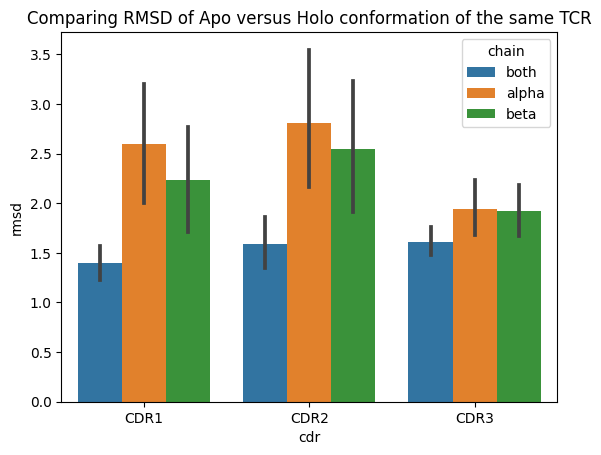

In [4]:
apo_holo = cdr_pw.query('structure1_pose != structure2_pose')
sns.barplot(data=apo_holo, y='rmsd', x='cdr', hue='chain')
plt.title('Comparing RMSD of Apo versus Holo conformation of the same TCR')

apo_holo.groupby(['cdr', 'chain'])['rmsd'].describe()

The following plots aim to depict the same information as above, except only looking at the comparison between *apo* structures, and comparison between *holo* structures. It is important to note that these do not represent all of the *apo* and all of the *holo* form TCRs, just those that were used for the above analysis. In this regard, they serve as a background for the inherent flexibility in these two states. A somewhat suspected finding of this is that the CDR3 domain shows the greatest amount of flexibility in its *apo* state. Flexiblity is relatively equal across all CDRs in the *holo* state.

count      mean       std       min       25%       50%   
pose cdr  chain                                                             
apo  CDR1 alpha    49.0  0.693489  0.601471  0.078380  0.356785  0.492290  \
          beta     48.0  0.560271  0.330976  0.069273  0.331135  0.486011   
          both     48.0  0.663880  0.468312  0.166940  0.362591  0.504723   
     CDR2 alpha    49.0  0.846405  0.449932  0.077065  0.475380  0.821703   
          beta     48.0  0.610925  0.316315  0.187917  0.354132  0.526314   
          both     49.0  0.772389  0.340887  0.192188  0.551005  0.759279   
     CDR3 alpha    49.0  1.141938  0.916364  0.107567  0.413600  0.793002   
          beta     48.0  0.873032  0.833626  0.117038  0.377244  0.541409   
          both     49.0  1.060177  0.822938  0.182471  0.447261  0.762518   
holo CDR1 alpha  1980.0  0.699322  2.977389  0.069101  0.208418  0.305620   
          beta   1980.0  0.664155  2.669652  0.038233  0.185530  0.342111   
          both   1979.0  0.478663  0.891355  0.057732  0.210631  0.342536   
     CDR2 alpha  1980.0  0.849071  3.459942  0.051782  0.188006  0.520552   
          beta   1980.0  0.726848  3.163888  0.041616  0.187125  0.343234   
          both   1981.0  0.582407  1.279501  0.068827  0.193154  0.476055   
     CDR3 alpha  1980.0  0.475229  1.424077  0.062014  0.192512  0.245756   
          beta   1980.0  0.887068  1.290860  0.096018  0.354534  0.700623   
          both   1981.0  0.706405  0.699330  0.082964  0.333897  0.592137   

                      75%        max  
pose cdr  chain                       
apo  CDR1 alpha  0.854465   3.087177  
          beta   0.669317   1.686311  
          both   0.777414   2.326782  
     CDR2 alpha  1.121149   1.817759  
          beta   0.799937   1.464916  
          both   0.964987   1.664230  
     CDR3 alpha  2.122825   3.374037  
          beta   1.100130   4.555960  
          both   1.551054   3.869210  
holo CDR1 alpha  0.413182  28.639649  
          beta   0.496883  25.998998  
          both   0.458504   8.812968  
     CDR2 alpha  0.660098  32.946938  
          beta   0.471656  30.080519  
          both   0.582457  12.387157  
     CDR3 alpha  0.334898  13.952567  
          beta   1.089460  12.667613  
          both   0.877232   7.321526

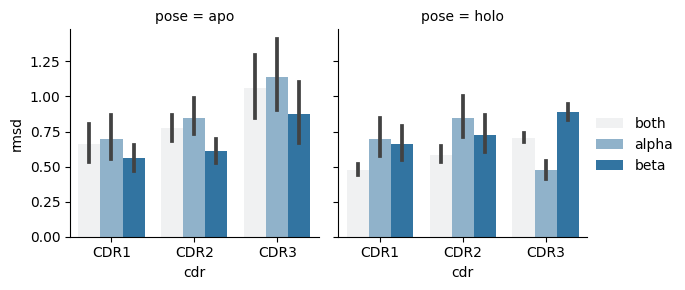

In [5]:
same_pose = cdr_pw.query('structure1_basename != structure2_basename').query("structure1_pose == structure2_pose").copy().reset_index()
same_pose['pose'] = same_pose['structure1_pose']

grid = sns.FacetGrid(same_pose, col='pose')
grid.map_dataframe(sns.barplot, y='rmsd', x='cdr', hue='chain')
grid.add_legend()

same_pose.groupby(['pose', 'cdr', 'chain'])['rmsd'].describe()

## Example of large RMSD

In [6]:
max_rmsd = cdr_pw.loc[cdr_pw['rmsd'].idxmax()]
print(max_rmsd)

view = nglview.show_file(max_rmsd['structure1'])
view.add_component(max_rmsd['structure2'])
view

id                                                                    26
structure1             /project/koohylab/bmcmaste/projects/tcr-loop-c...
structure2             /project/koohylab/bmcmaste/projects/tcr-loop-c...
chain                                                              alpha
cdr                                                                 CDR2
rmsd                                                           32.950232
structure1_basename                                     3tpu_BA_holo.pdb
structure2_basename                                      3tf7_Ii_apo.pdb
combined_name                           3tf7_Ii_apo.pdb-3tpu_BA_holo.pdb
structure1_pose                                                     holo
structure2_pose                                                      apo
Name: 36430, dtype: object


NGLWidget()

## Looking at the percentage of examples where there is changes between *apo* and *holo* conformations

In [23]:
TOLERANCE = 0.1
(apo_holo['rmsd'] > TOLERANCE).value_counts()

rmsd
True    3542
Name: count, dtype: int64